# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving
import h5py

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Model

## Model Functions

In [8]:
model_fxns = model.Model(model.M2a, model.run_ss, model.simulate_wt_experiment, t100a=model.simulate_t100a_experiment_M2a)

## Model Variables (Constants)

In [6]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)
# steps = 3001
time2 = np.linspace(0,dt*3001,steps)

MAP3K_t = model_supp.molarity_conversion(123+1207+1611) #ssk2+ssk22+ste11
MAP2K_t = model_supp.molarity_conversion(4076)
MAPK_t = model_supp.molarity_conversion(8225)
PTP_t = model_supp.molarity_conversion(443+1324) # ptp2+ptp3

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on


labelnames = ['$- fb$', '$+ fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK, gly]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

doses = [150000, 550000]
wt_doses = [150000, 550000]
t100a_doses = [150000, 550000]

# Load experimental data

In [7]:
exp_data, exp_time = model_supp.get_data(local=True)

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, hog1_ramp_inhib_data, pbs2_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_0 = [mapk_t100a_data[0]] 
mapk_time_t100a_0 = [0, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_wt_data = [mapk_wt_data[2], mapk_wt_data[6]]
mapk_t100a_data = [mapk_t100a_data[2], mapk_t100a_data[6]]

# Load simulation data

In [9]:
folder = '../../sim_data/EA/200904_M2a/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)

Number of runs collected: 1449
Best last gen MSE: 21733.23423846377
Mean last gen MSEs of top 5%: 25842.696804510328


# EA Results

## Checking first generation sampling distributions

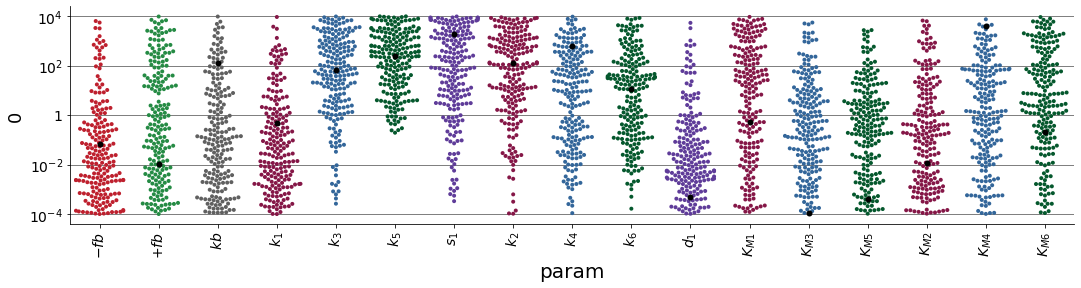

In [10]:
sorted_mses_EA_firstg, sorted_thetas_EA_firstg = model_supp.sort_sses_thetas(all_mses[:,0], all_params[:,0,:])

num_plt = 200
df_plt = pd.DataFrame(sorted_thetas_EA_firstg[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0, plot='swarm') #black dot is best param

## Final SSE results

No handles with labels found to put in legend.


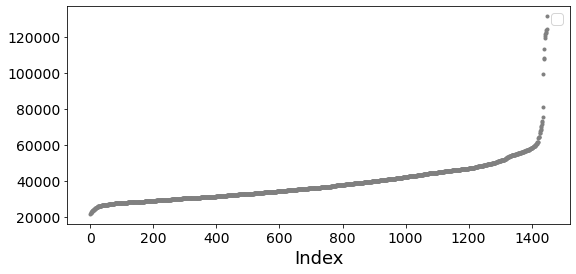

In [11]:
plotting.plt_idx_vs_sse(last_mses, len(last_mses))

## Recalculate SSE

No handles with labels found to put in legend.


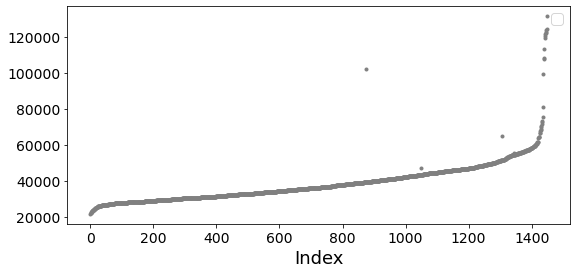

In [12]:
## sort and check MSE calculation
sorted_sses_EA, sorted_thetas_EA = model_supp.sort_sses_thetas(last_mses, last_params)

sse_check = model_supp.recalculate_score(sorted_thetas_EA, model_fxns, exp_data, exp_time, params_constants, initials)
    
plotting.plt_idx_vs_sse(sse_check, len(sse_check), sorting=False)

No handles with labels found to put in legend.


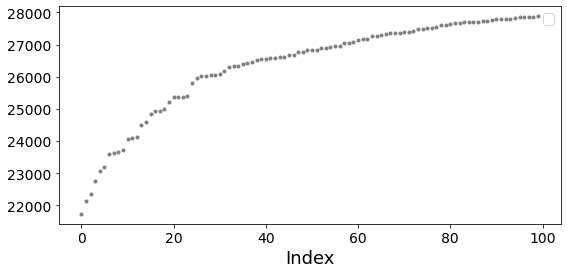

In [13]:
# Resort recalculated parameter values
sorted_sses_EA, sorted_thetas_EA = model_supp.sort_sses_thetas(sse_check, sorted_thetas_EA)
plotting.plt_idx_vs_sse(sorted_sses_EA, 100)

## SSE over generations

<Figure size 720x576 with 0 Axes>

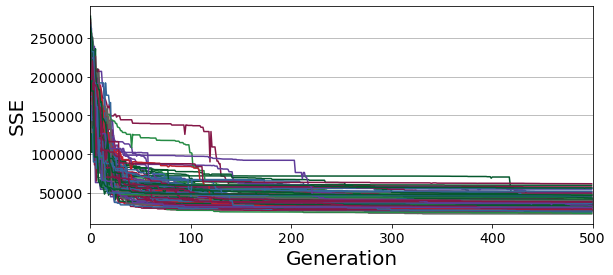

In [14]:
plotting.plt_sses_gen(500,all_mses,100)

## Parameter Distributions

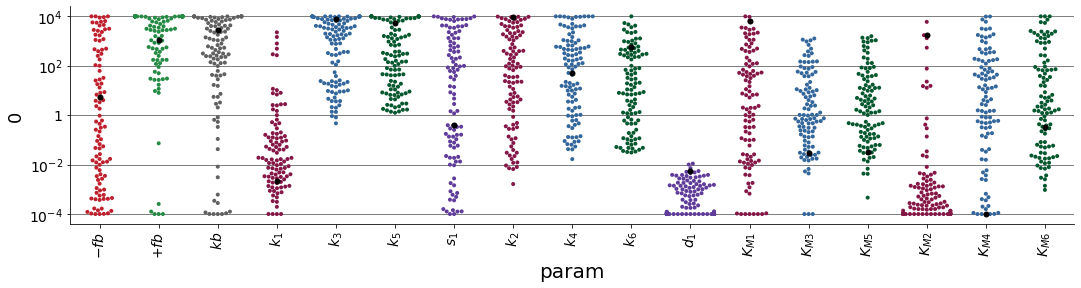

In [15]:
df_top_thetas_EA = pd.DataFrame(sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

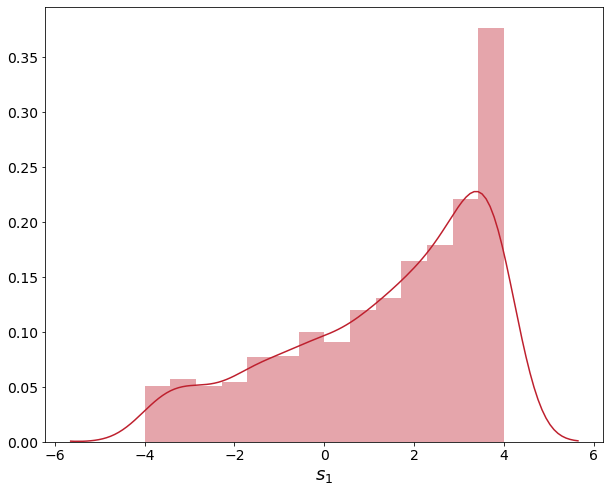

In [16]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

## Fits with Standard Deviation

Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

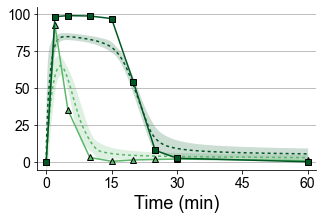

In [17]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

In [18]:
# plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  [0], time_long, 2,
#                         exp_data=mapk_data_t100a_0, exp_time=mapk_time_t100a_0, ss=True, t100a=False, ptpD=False, ci='sd',
#                         save_fig='')

Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

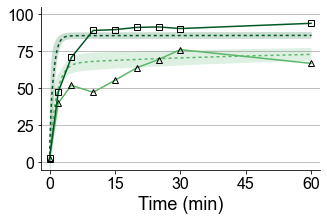

In [19]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

Dose: 0 complete.


<Figure size 720x576 with 0 Axes>

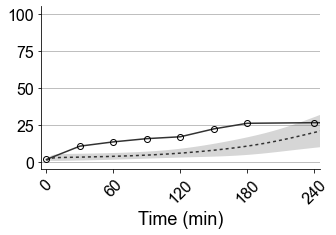

In [20]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  [0], time2, 2,
                        exp_data=mapk_data_t100a_0, exp_time=mapk_time_t100a_0, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

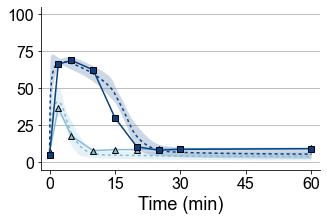

In [21]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

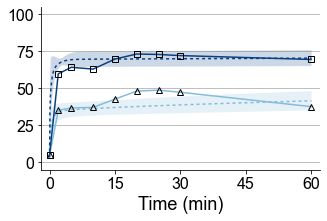

In [22]:
plotting.plt_param_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials,  wt_doses, time, 1,
                        exp_data=map2k_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


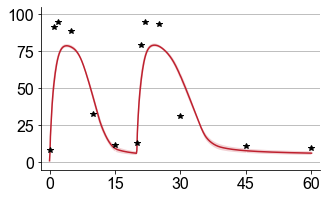

In [23]:
plotting.plt_ramp_cis(model_fxns, sorted_thetas_EA[:10], params_constants, initials, time, 0, ramp_data=hog1_ramp_data, ramp_time=mapk_ramp_time)

## Individual Runs

<Figure size 720x576 with 0 Axes>

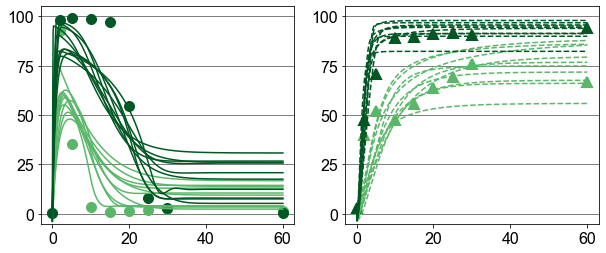

In [81]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

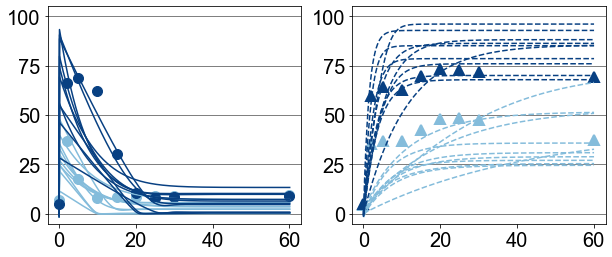

In [82]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

<Figure size 720x576 with 0 Axes>

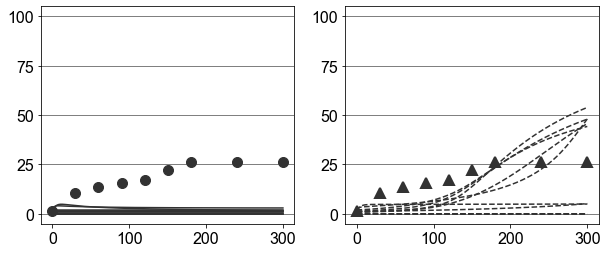

In [25]:
plotting.plt_param_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials,  [0], time2, 2, mapk_data_t100a_0, mapk_data_t100a_0, mapk_time_t100a_0,ss=True)

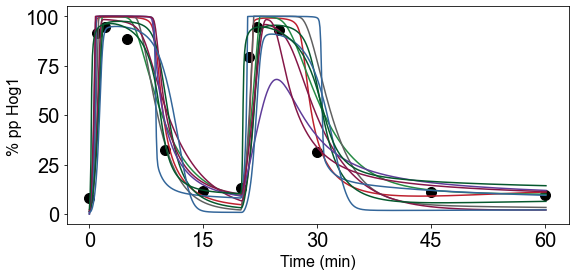

In [26]:
plotting.plt_ramp_behaviors(model_fxns, sorted_thetas_EA, 10, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

# ABC SMC

## Check recalculation of EA MSEs

In [24]:
base_name = '200904_M2b_abc_smc'

base_f = '../../sim_data/ABC_SMC/' + base_name + '/'

### EA recalc

In [25]:
ea = h5py.File(base_f+base_name+'_0000.hdf5', 'r')

ea_thetas = ea['thetas']
ea_mses = ea['mses']

No handles with labels found to put in legend.


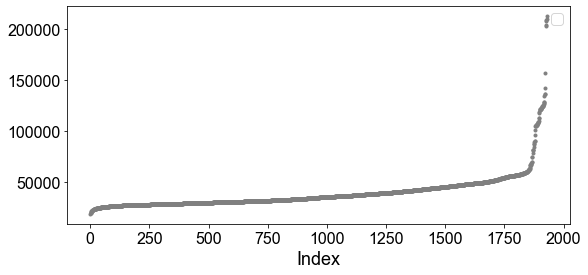

In [26]:
plotting.plt_idx_vs_sse(ea_mses, len(ea_mses))

No handles with labels found to put in legend.


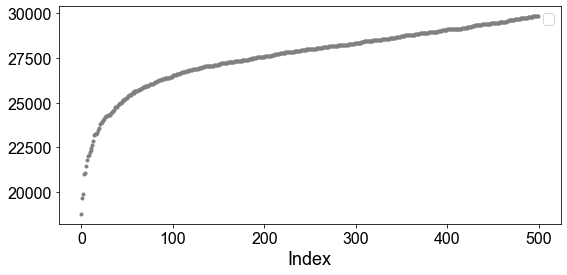

In [27]:
plotting.plt_idx_vs_sse(ea_mses, 500)

Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

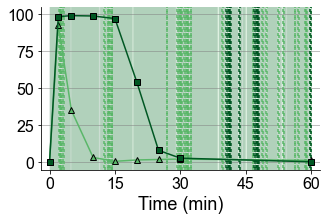

In [28]:
plotting.plt_param_cis(model_fxns, ea_thetas, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

## Last schedule result

In [29]:
e6 = h5py.File(base_f+base_name+'_0006.hdf5', 'r')
e6_thetas = e6['thetas']
e6_mses = e6['mses']

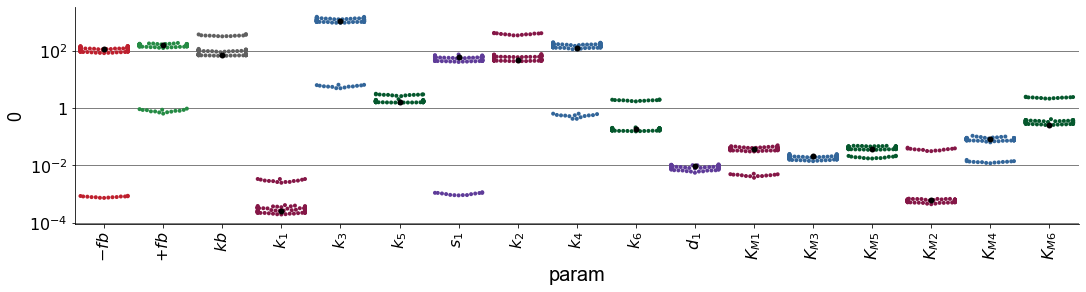

In [33]:
# df_top_thetas_EA = pd.DataFrame(np.array(e4_thetas))
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(e6_thetas[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

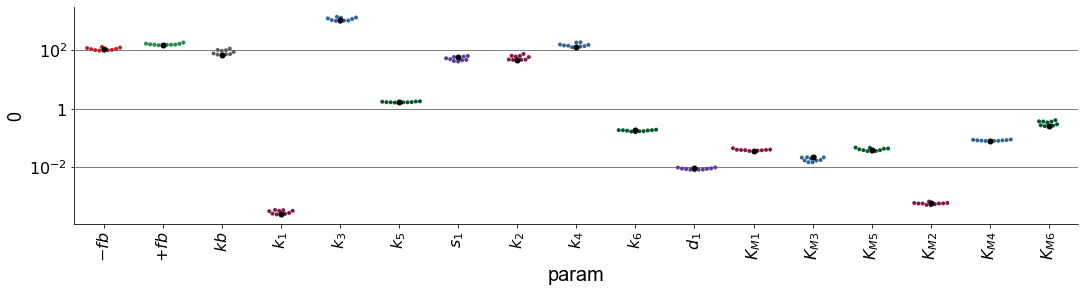

In [32]:
# df_top_thetas_EA = pd.DataFrame(np.array(e4_thetas))
# df_top_thetas_EA.columns = labelnames

num_plt = 10
df_plt = pd.DataFrame(e6_thetas[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

In [ ]:
plotting.plt_idx_vs_sse(e6_mses, 1000)

### No Positive Feedback

In [112]:
base_save = '../Figures/'

Dose: 150000 complete.
Dose: 350000 complete.


No handles with labels found to put in legend.


Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

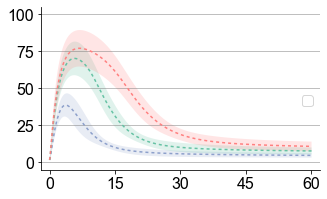

In [44]:
plotting.plt_param_cis_pos_predictions(model_fxns, e6_thetas, params_constants, initials,  [150000,350000,550000], time, 2,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='') #base_save+'/B/4B_00'

### No Negative Feedback

No handles with labels found to put in legend.


Dose: 150000 complete.
Dose: 550000 complete.


<Figure size 720x576 with 0 Axes>

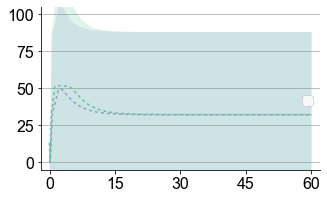

In [71]:
plotting.plt_param_cis_neg_predictions(model_fxns, e6_thetas[:5], params_constants, initials,  doses, time, 2,
                        exp_data=None, exp_time=None, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

### Predict Justin's data

In [45]:
j_data, j_time = model_supp.get_Justin_data()
j_wt, j_t100a = j_data

In [46]:
j_wt_data_pred = [j_wt[3],j_wt[4],j_wt[5]]
j_t100a_data_pred = [j_t100a[3],j_t100a[4],j_t100a[5]]

Dose: 250000 complete.
Dose: 350000 complete.
Dose: 450000 complete.


<Figure size 720x576 with 0 Axes>

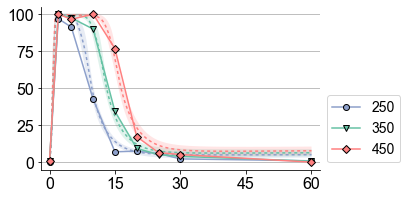

In [50]:
plotting.plt_param_cis_justin_predictions(model_fxns, e6_thetas, params_constants, initials,  [250000,350000,450000], time, 2,
                        exp_data=j_wt_data_pred, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig='')

Dose: 250000 complete.
Dose: 350000 complete.
Dose: 450000 complete.


<Figure size 720x576 with 0 Axes>

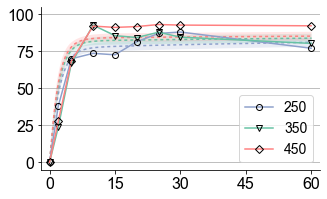

In [52]:
plotting.plt_param_cis_justin_predictions(model_fxns, e6_thetas, params_constants, initials,  [250000,350000,450000], time, 2,
                        exp_data=j_t100a_data_pred, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig='')

# Sensitivity Analysis

In [53]:
best_param_set = e6_thetas[0].copy()

In [244]:
def scan_param(param_vec, param_to_change, scan_range):
    scores = []
    for x in scan_range:
        _param = step_size(param_vec,param_to_change,x)
        _score = model_supp.calc_sim_score(model_fxns, exp_data, exp_time, params_constants, initials, _param, ptpD=False, full=True, convert = (False,))
        scores.append(_score)
    return np.array(scores)

def calc_norm_sensitivity(param_vec, param_to_change, original_mse, step=0.001):
    #step_size as a percentage of the param value
#     for i in [+, -]:
    param_1 = param_vec.copy()
    param_1[param_to_change] = param_1[param_to_change] + param_1[param_to_change]*step #0.001
    mse_1 = model_supp.calc_sim_score(model_fxns, exp_data, exp_time, params_constants, initials, param_1, ptpD=False, full=True, convert = (False,))
    mse_1 = sum(mse_1[:18])
    
    param_2 = param_vec.copy()
    param_2[param_to_change] = param_2[param_to_change]-param_2[param_to_change]*step #0.001
    mse_2 = model_supp.calc_sim_score(model_fxns, exp_data, exp_time, params_constants, initials, param_2, ptpD=False, full=True, convert = (False,))
    mse_2 = sum(mse_2[:18])
#     print(original_mse)
    
#     sensitivity_norm = ((mse_1-mse_2)/original_mse)/(2*step/param_vec[param_to_change])
#     sensitivity_norm = (np.abs(mse_1-mse_2)/original_mse)/(2*step)

#     sensitivity_norm = ((mse_1-original_mse)+(mse_2-original_mse)/original_mse)/(2*step/param_vec[param_to_change])
#     sensitivity_norm = ((mse_1-original_mse)+(mse_2-original_mse))/(2*step)
#     sensitivity_norm = ((mse_1+mse_2)/2/original_mse)
#     sensitivity_norm = ((mse_1-mse_2)/(2*step))*(param_vec[param_to_change]/original_mse) # correct one
    sensitivity_norm = ((mse_1-mse_2)/(2*step))*(param_vec[param_to_change]/original_mse) # correct one
    
    return sensitivity_norm

# def take_perc():

In [228]:
def sensitivity_analysis(param_set,pred=False):
    sa_values = []
    for param_s in param_set:
#         original_mses = []
        data = []
        original_mse = sum(model_supp.calc_sim_score(model_fxns, exp_data, exp_time, params_constants, initials, param_s, ptpD=False, full=True, convert = (False,))[:18])
#         print(mse)
        for param in range(len(param_s)):
#             if pred:
#                 _mse = mse[18]
#             else:
#                 _mse = sum(mse[:18])#+mse[19]
#             original_mses.append(_mse)
            
            sensitivity_norm = calc_norm_sensitivity(param_s, param, original_mse, step=0.001)
#             print(sensitivity_norm)
#             if pred:
#                 t_mse = [x[18] for x in mses]
#             else:
#                 t_mse = [sum(x[:18]) for x in mses] #+x[19]
            
            data.append(sensitivity_norm)
            
#         sum_mse = np.sum(np.array(data), axis = 1)/np.array(original_mses)
        sa_values.append(data)
    return np.array(sa_values)



# test_range = np.logspace(-2,2,num=10)
# test = scan_param(best_param_set, 0, test_range)

In [245]:
sa_values_ea = sensitivity_analysis(e6_thetas[0:10],pred=False)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


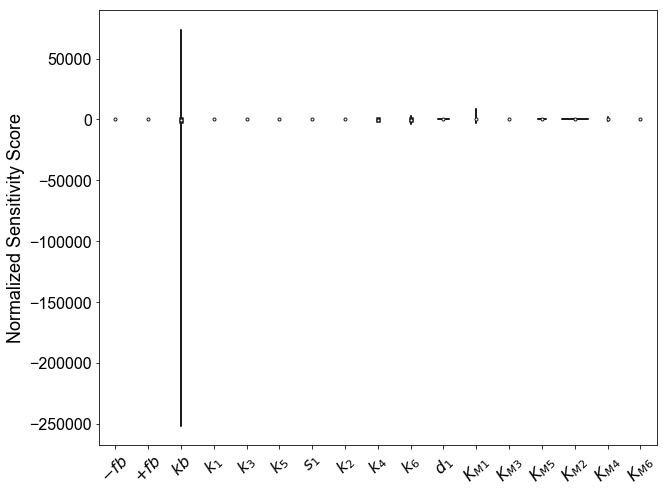

In [247]:
# sensitivity of top param set
sa_df_ea = pd.DataFrame(sa_values_ea, columns=labelnames)
# sa_df_ea = np.log10(sa_df_ea)
# test2 = test2.replace([np.inf, -np.inf], np.nan)

# ax = sns.barplot(data = sa_df_ea)
ax = sns.violinplot(data = sa_df_ea)
# ax = sns.swarmplot(data = sa_df_ea)


ax.set(xticklabels=labelnames)
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
# plt.ylim(.5,4)
# plt.axhline(y=1, color = 'grey')
plt.ylabel('Normalized Sensitivity Score')
plt.show()

In [254]:
test = e6_thetas[0].copy()
test[0] = test[0]+test[0]*.001

In [255]:
model_supp.sim_all(model_fxns, exp_data, exp_time, params_constants, initials, e6_thetas[0], test, ptpD=False, full=True, convert = (False,))

[0.00000000e+00 5.01582868e-05 6.35858193e-05 7.77948491e-05
 9.46140131e-05 1.16213655e-04 1.45007698e-04 1.83616598e-04
 2.34753168e-04 3.00892719e-04 3.83539574e-04 4.81628687e-04
 5.88442547e-04 6.86751029e-04 7.47844346e-04 7.53987302e-04
 7.33072597e-04 7.18853525e-04 7.14850216e-04 7.15677687e-04
 7.18334673e-04 7.21762308e-04 7.25507307e-04 7.29516970e-04
 7.33740957e-04 7.38174075e-04 7.42793078e-04 7.47610997e-04
 7.52641029e-04 7.57879081e-04 7.63340381e-04 7.69035370e-04
 7.74976142e-04 7.81177884e-04 7.87653789e-04 7.94420993e-04
 8.01499815e-04 8.08910549e-04 8.16673916e-04 8.24814043e-04
 8.33357441e-04 8.42336203e-04 8.51783755e-04 8.61731894e-04
 8.72220148e-04 8.83289906e-04 8.94981686e-04 9.07338411e-04
 9.20435688e-04 9.34326324e-04 9.49109209e-04 9.64831392e-04
 9.81619779e-04 9.99526908e-04 1.01871371e-03 1.03928764e-03
 1.06139031e-03 1.08516616e-03 1.11078642e-03 1.13844707e-03
 1.16835588e-03 1.20076548e-03 1.23593549e-03 1.27415602e-03
 1.31577100e-03 1.361131

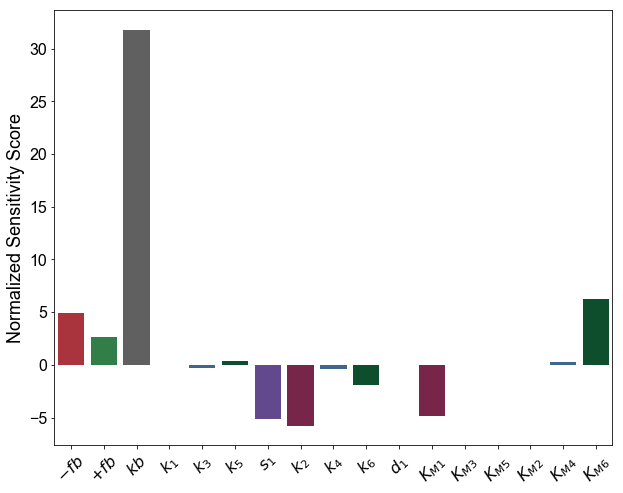

In [156]:
sa_df_ea = pd.DataFrame(sa_values_ea[0:1], columns=labelnames)
# sa_df_ea = np.log10(sa_df_ea)
# test2 = test2.replace([np.inf, -np.inf], np.nan)

ax = sns.barplot(data = sa_df_ea)
ax.set(xticklabels=labelnames)
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
# plt.ylim(.5,4)
# plt.axhline(y=1, color = 'grey')
plt.ylabel('Normalized Sensitivity Score')
plt.show()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


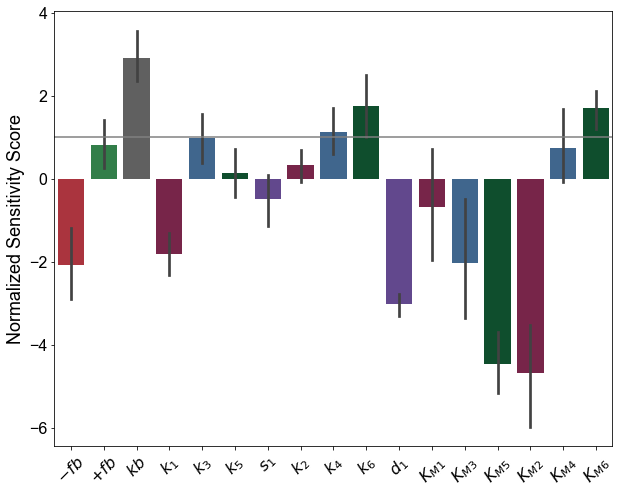

In [139]:
sa_values_ea = sensitivity_analysis(e6_thetas[0:10],pred=False)
# sensitivity of top param set
sa_df_ea = pd.DataFrame(sa_values_ea, columns=labelnames)
sa_df_ea = np.log10(sa_df_ea)
# test2 = test2.replace([np.inf, -np.inf], np.nan)

ax = sns.barplot(data = sa_df_ea)
ax.set(xticklabels=labelnames)
plt.xticks(rotation=45)
plt.yticks(rotation='horizontal')
# plt.ylim(.5,4)
plt.axhline(y=1, color = 'grey')
plt.ylabel('Normalized Sensitivity Score')
plt.show()

In [77]:
best_score = model_supp.calc_sim_score(model_fxns, exp_data, exp_time, params_constants, initials, best_param_set,ptpD=False, full=True, convert = (False,) )

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5,0,'$\\Delta p$ (normalized to original value)')

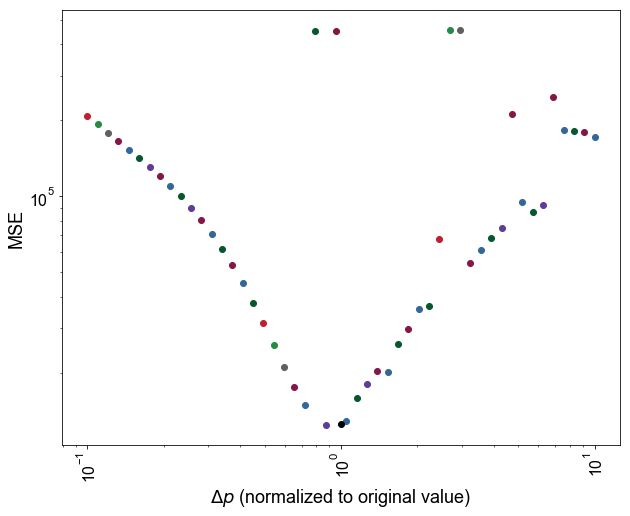

In [83]:
num = 16
test_range = np.logspace(-1,1,num=50)
test = scan_param(best_param_set, num, test_range)

# for y, r, p in zip(test,test_range,pal):    
#     plt.loglog(r,sbum(y[:18])+y[19], 'o', label = np.around(r*best_param_set[0],5), color = p)
for y, r in zip(test,test_range):    
    plt.loglog(r,sum(y[:18]), 'o', label = np.around(r*best_param_set[0],5))


plt.loglog(1, sum(best_score[:18]), 'o', color='black', label = np.around(best_param_set[num], 5))
# plt.yscale('log')
plt.xticks(rotation='vertical')
plt.ylabel('MSE')
plt.xlabel('$\Delta p$ (normalized to original value)')
# plt.legend()